# Описание бизнес-задачи

Представьте, что вы аналитик в крупной сети ритейл-магазинов. Вас просят построить систему прогнозирования продаж товаров на 1 неделю вперед, чтобы понимать, сколько товаров завозить в магазин на следующей неделе. Также вас просят оценить точность вашего прогноза, чтобы понимать, насколько хорош ваш алгоритм и насколько можно ему доверять.

Руководство компании предоставило вам даны данные о продаже разных категорий товаров в крупном магазине по дням и по часам. В этих данных есть следующие колонки:

- `category_id` - id категории
- `date` - дата
- `hour` - час, за который отсчитывается число продаж
- `num_sells_in_hour` - число продаж этого товара за один час

Как вы понимаете, перед вами данные из реальной жизни. Поэтому какие-то товары могут быть очень новыми и у них слишком короткая история для прогнозирования продаж для них. Некоторые товары дорогие и покупаются не каждый час. В общем все, что присуще продажам товаров в магазинах.

Вам дают две недели на решение этой задачи. Через две недели вас попросят рассказать директору отдела закупок о том, какую систему вы построили, как она работает и насколько она хороша.

Очень желательно, чтобы происходящее в вашем отчете было по возможности проиллюстрировано графиками, так как директору отдела закупок легче воспринимать информацию в графическом виде.

Это было описание бизнес-кейса. Давайте теперь сформулируем техническое задание к данному бизнес-кейсу

## Задача прогнозирования продаж в сети ритейл-магазинов

**Вопрос:** Какую задачу решает мой проект?

**Ответ:** Прогнозирование продаж товаров на неделю вперед для планирования завоза товаров в магазины

**Вопрос:** Какие зависимости я хочу исследовать, на какие вопросы по данным я хочу ответить?

**Ответ:**
- Есть ли в данных внутридневная/внутринедельная сезонность?
- Какой алгоритм лучше всего (по метрикам качества) сможет строить прогноз?
- С какой точностью можно спрогнозировать продажи товаров по трехмесячной истории продаж категории?

**Вопрос:** Откуда я возьму для него данные?

**Ответ:** Предоставило руководство магазина

**Вопрос:** Какие подходы я хочу попробовать и почему? (тезисно)

**Ответ:** Линейная регрессия и Prophet, потому что линейная регрессия - это простой метод регрессии, а Prophet хорошо подходит для временнЫх рядов

**Вопрос:** Какова целевая функция, как оценить результат?

**Ответ:** Mean Squared Error (MSE), Mean Absolute Error (MAPE)

# Подробнее про оценку качества алгоритма прогнозирования:
- разбить данные на **train** и **test**
- обучиться на **train**, применить алгоритм к **test**
- посчитать метрики MSE и MAPE

Используйте любые знания, инструменты и навыки, которые мы освоили за время курса.
Код не первостепенен. Первостепенны графики, ваши мысли по этим графикам, и выводы, которые вы из них делаете.

Строгих правил оформления работы нет, делайте, как считаете правильным.

В случае появления неопределенностей, руководствуйтесь здравым смыслом.

Гораздо важнее ваши мысли, чем то, как вы их реализуете.

Примечания:

- вам пригодится руководство по Prophet, его можно найти здесь: https://facebook.github.io/prophet/docs/quick_start.html#python-api
- чтобы прогнозировать временной ряд с помощью Prophet, нужно сагрегировать данные по часам внутри одного дня в сумму за день, и уже в таком виде подавать на вход в Prophet
- чтобы работать с Prophet, вам нужно будет работать в Google Colab. А это значит, что вам нужно научиться заливать данные на гугл-диск и подключать их colab-ноутбуку)

P.S. Верхнеуровнево план этой работы такой:
- сагрегировать данные по часам в дни
- обучить алгоритм прогнозирования
- посчитать метрики качества

Дерзайте!

## 1. Исследовательский анализ данных

### Вопросы, на которые стоит ответить при первичном анализе данных:

- для какого количества товаров вам дана информация о ежедневных продажах?
- за какие даты вам даны данные? Какая максимальная длина истории продаж (в днях) доступна в данных?
- сколько товаров имеют полную (равную максимальной длине) историю?
- что делать с товарами с неполной историей?

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
from tqdm import tqdm_notebook

In [ ]:
df = pd.read_csv("/content/dataset.csv")
df.head()

,category_id,date,hour,num_sells_in_hour
0,8940,2018-05-25,8,16
1,8940,2018-05-25,9,22
2,8940,2018-05-25,10,15
3,8940,2018-05-25,11,24
4,8940,2018-05-25,12,22


In [ ]:
df.shape

(97047, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97047 entries, 0 to 97046
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category_id        97047 non-null  int64 
 1   date               97047 non-null  object
 2   hour               97047 non-null  int64 
 3   num_sells_in_hour  97047 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 3.0+ MB


In [ ]:
[pd.unique(df['date']), pd.unique(df['category_id'])]

[array(['2018-05-25', '2018-05-26', '2018-05-27', '2018-05-28',
        '2018-05-29', '2018-05-30', '2018-05-31', '2018-06-01',
        '2018-06-02', '2018-06-03', '2018-06-04', '2018-06-05',
        '2018-06-06', '2018-06-07', '2018-06-08', '2018-05-03',
        '2018-05-04', '2018-05-05', '2018-05-06', '2018-05-07',
        '2018-05-08', '2018-05-09', '2018-05-10', '2018-05-11',
        '2018-05-12', '2018-05-13', '2018-05-14', '2018-05-15',
        '2018-05-16', '2018-05-17', '2018-05-18', '2018-05-19',
        '2018-05-20', '2018-05-21', '2018-05-22', '2018-05-23',
        '2018-05-24'], dtype=object),
 array([ 8940,  8952,  8956,  8964, 11184, 11656, 11688, 12454,   984,
          994,   999,  1004,  1009,  1019,  1024,  1029,  4009,  5009,
         5024,  5029,  5749,  5839,  7659,  7664,  8999,  9004,  9009,
         9014, 13499, 13509, 13529, 13609, 13644, 13689, 13729, 10092,
        10132, 10142, 13807, 13812,  3700,  3705,  3710,  6175,  6195,
        10670, 10690, 10715, 10

In [ ]:
df['category_id'].nunique ()

181

In [ ]:
df_n = df.drop(columns = ['hour', 'num_sells_in_hour'], axis = 1)
df_n = df_n.drop_duplicates(keep='first')
df_n['category_id'].value_counts().to_frame().value_counts()#max - без to_frame


category_id
37             135
9                5
30               4
29               4
22               4
21               3
36               2
28               2
26               2
23               2
1                2
16               2
12               2
8                2
19               1
2                1
15               1
14               1
27               1
7                1
6                1
35               1
5                1
20               1
dtype: int64

- дана инофрмация о 181 товаре
- даты: 03 мая 2018 - 8 июня 2018, максимаьная длина - 37
-товаров с макс. длиной - 135
- тех, которых не хватает - пусть

## 2. Исследовательский анализ данных

### Вопросы, на которые стоит ответить при исследовательском анализе данных:

- как выглядят почасовые графики продаж товаров?
- Есть ли в почасовых графиках продаж какая-то общая зависимость/паттерн?
- когда люди совершают больше покупок в магазине - в обед или вечером?
- как выглядят подневные графики продаж товаров?
- можно ли визуально из графиков определить направление тренда (возрастающий/убывающий)?

In [ ]:
[pd.unique(df['date']), pd.unique(df['category_id'])]

[array(['2018-05-25', '2018-05-26', '2018-05-27', '2018-05-28',
        '2018-05-29', '2018-05-30', '2018-05-31', '2018-06-01',
        '2018-06-02', '2018-06-03', '2018-06-04', '2018-06-05',
        '2018-06-06', '2018-06-07', '2018-06-08', '2018-05-03',
        '2018-05-04', '2018-05-05', '2018-05-06', '2018-05-07',
        '2018-05-08', '2018-05-09', '2018-05-10', '2018-05-11',
        '2018-05-12', '2018-05-13', '2018-05-14', '2018-05-15',
        '2018-05-16', '2018-05-17', '2018-05-18', '2018-05-19',
        '2018-05-20', '2018-05-21', '2018-05-22', '2018-05-23',
        '2018-05-24'], dtype=object),
 array([ 8940,  8952,  8956,  8964, 11184, 11656, 11688, 12454,   984,
          994,   999,  1004,  1009,  1019,  1024,  1029,  4009,  5009,
         5024,  5029,  5749,  5839,  7659,  7664,  8999,  9004,  9009,
         9014, 13499, 13509, 13529, 13609, 13644, 13689, 13729, 10092,
        10132, 10142, 13807, 13812,  3700,  3705,  3710,  6175,  6195,
        10670, 10690, 10715, 10

In [ ]:
df = pd.read_csv("/content/dataset.csv")
df.head()
df_q = df.drop(columns = ['category_id', 'date'], axis = 1)
df_q = df_q.groupby('hour').sum()
df_q.reset_index(inplace= True )
df_q

,hour,num_sells_in_hour
0,0,5
1,3,5
2,4,17469
3,5,37143
4,6,61383
5,7,78488
6,8,90521
7,9,95013
8,10,94651
9,11,90253


Text(0.5, 1.0, 'Зависимость продаж от времени')

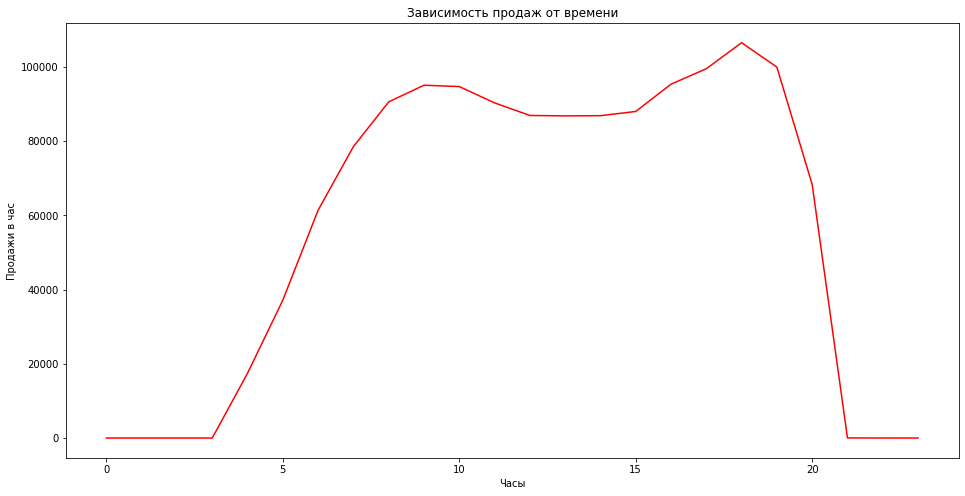

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(df_q['hour'], df_q['num_sells_in_hour'], 'r')
ax.set_xlabel('Часы')
ax.set_ylabel('Продажи в час')
ax.set_title('Зависимость продаж от времени')

Пики "активности" приходятся на 6 вечера и 9 утра. (При этом в целом объём продаж во время вечерней активности больше, чем на утраенний)




In [ ]:
df = pd.read_csv("/content/dataset.csv")
df.head()
df_1 = df.drop(columns = ['category_id', 'hour'], axis = 1)
df_1 = df_1.groupby('date').sum()
df_1.reset_index(inplace= True )
df_1

,date,num_sells_in_hour
0,2018-05-03,34878
1,2018-05-04,36116
2,2018-05-05,37279
3,2018-05-06,37377
4,2018-05-07,37975
5,2018-05-08,34596
6,2018-05-09,33836
7,2018-05-10,34508
8,2018-05-11,37209
9,2018-05-12,38416


Text(0.5, 1.0, 'Продажи по датам')

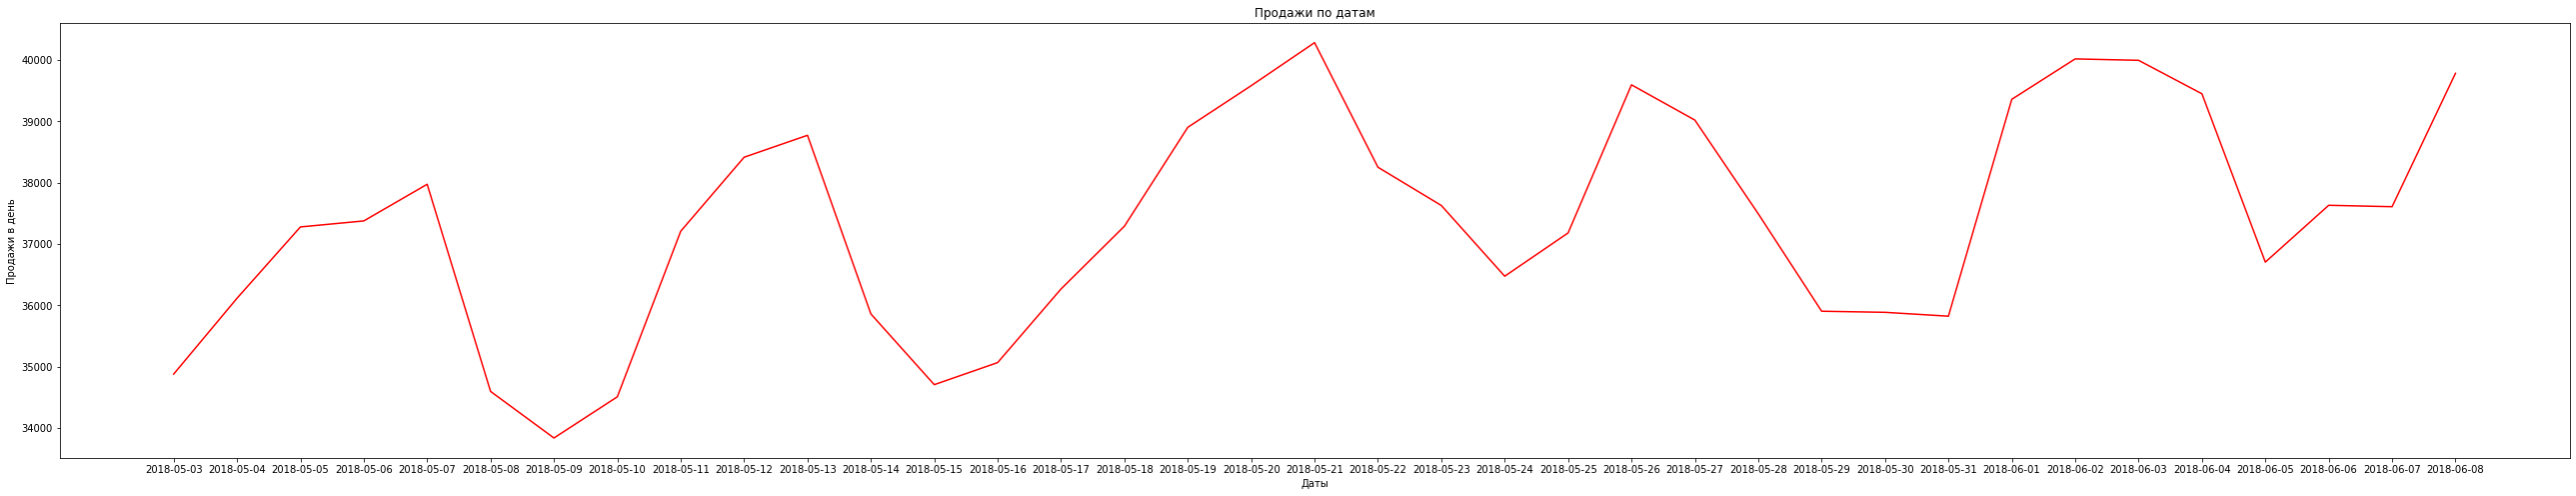

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(45, 8))
ax.plot(df_1['date'], df_1['num_sells_in_hour'], 'r')
ax.set_xlabel('Даты')
ax.set_ylabel('Продажи в день')
ax.set_title('Продажи по датам')

Визуально наблюдается возрастающая подневная тенденция
"Дно" продаж приходится на середины рабочих неделей (среда-четверг)
Максимумы - на воскресенья-понедельники


## 3. Обучение алгоритмов прогнозирования

### Вопросы, на которые стоит получить ответ в части с обучением алгоритмов:
- как разбить данные на `train` и `test`, если нужно оценивать качество прогнозирования на 1 неделю вперед?
- какое усредненное по товарам MSE (Mean Squared Error) для ```Prophet```?
-
- какое усредненное по товарам MSE (Mean Squared Error) для линейной регрессии?
- у какого алгоритма ошибка получилась меньше?

1 неделя = 7 дней = 7/37=19%



Работаем по дням


### 3.1 Prophet

https://facebook.github.io/prophet/docs/quick_start.html



In [ ]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from prophet import Prophet
from sklearn.linear_model import LinearRegression

In [ ]:
df_1.rename(columns = {'date':'ds', 'num_sells_in_hour':'y'}, inplace = True)

df_1['ds'] = pd.to_datetime(df_1['ds'])

In [ ]:
df_tr = df_1.iloc [:30]
df_ts = df_1.iloc [30:]
df_ts['y']

30    40020
31    39997
32    39451
33    36705
34    37632
35    37609
36    39785
Name: y, dtype: int64

In [ ]:
m = Prophet()
m.fit(df_tr)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptgzladkz/zc5lkvap.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptgzladkz/6e1rcrd8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29604', 'data', 'file=/tmp/tmptgzladkz/zc5lkvap.json', 'init=/tmp/tmptgzladkz/6e1rcrd8.json', 'output', 'file=/tmp/tmptgzladkz/prophet_modelfa137pr5/prophet_model-20221201105352.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:53:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:53:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

In [ ]:
future = m.make_future_dataframe(periods=7)
future

,ds
0,2018-05-03
1,2018-05-04
2,2018-05-05
3,2018-05-06
4,2018-05-07
5,2018-05-08
6,2018-05-09
7,2018-05-10
8,2018-05-11
9,2018-05-12


In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()



,ds,yhat,yhat_lower,yhat_upper
32,2018-06-04,38615.806275,37563.612177,39711.045476
33,2018-06-05,36490.865500,35439.033947,37519.513075
34,2018-06-06,36172.696388,35179.466585,37217.023429
35,2018-06-07,36445.035626,35269.011231,37530.579989
36,2018-06-08,38217.314493,37058.498433,39350.326028


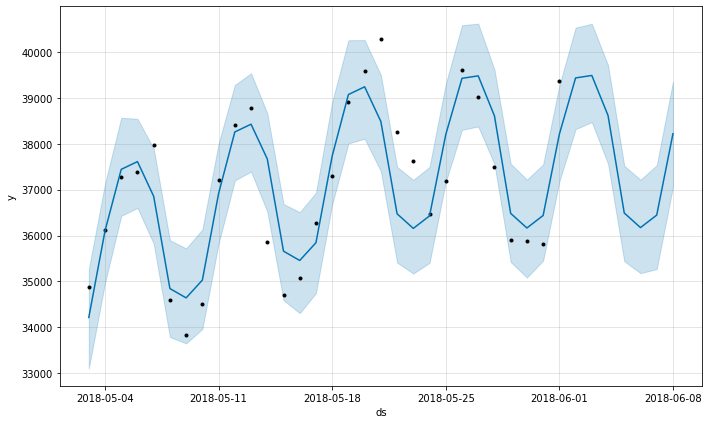

In [ ]:
fg1 = m.plot(forecast)

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_components_plotly(m, forecast)


In [ ]:
def MSE(y_true, y_pred):
    return np.power(y_true - y_pred, 2).mean()

In [ ]:
df_ts['y']

30    40020
31    39997
32    39451
33    36705
34    37632
35    37609
36    39785
Name: y, dtype: int64

In [ ]:
MSE(df_ts['y'],forecast['yhat'][30:])

1041168.7343871931

In [ ]:
def MAPE(y_true, y_pred):
    return (np.absolute(y_true - y_pred)/y_true).mean()

In [ ]:
MAPE(df_ts['y'],forecast['yhat'][30:])

0.02335877870365889

### 3.2 Линейная регрессия

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [ ]:
cols = df_1.shape[1]
X = df_1.iloc[:,0:cols-1]
X.insert(1, "ind", range(37), False)
X = X.drop(['ds'], axis = 1)
X_tr = X.iloc[:30, :]
X_ts = X.iloc[30:, :]
y = df_1.iloc[:,cols-1:cols]
y_tr = y.iloc[:30, :]
y_ts = y.iloc[30:, :]
X_tr


,ind
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


In [ ]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X_tr, y_tr)
regr.coef_

array([[69.06051168]])

In [ ]:
y_pred = regr.predict(X_ts)

Text(0.5, 1.0, 'Предсказание продаж')

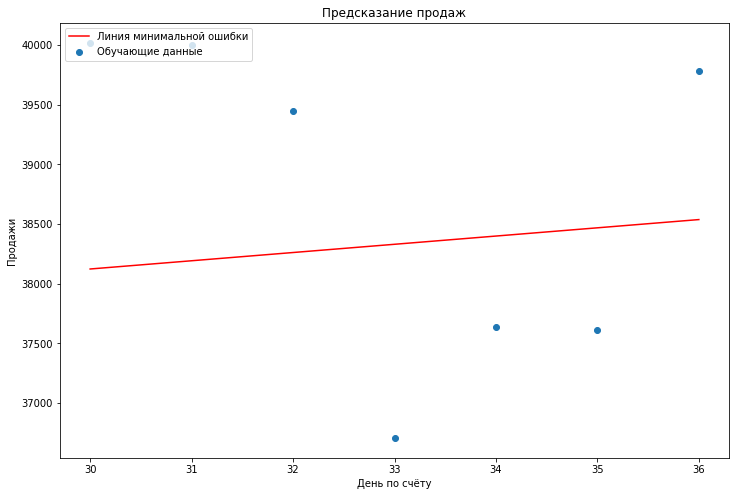

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(X_ts, y_pred, 'r', label='Линия минимальной ошибки')
ax.scatter(X_ts, y_ts, label='Обучающие данные')
ax.legend(loc=2)
ax.set_xlabel('День по счёту')
ax.set_ylabel('Продажи')
ax.set_title('Предсказание продаж')

In [ ]:
y_pred

array([[38122.13793103],
       [38191.19844271],
       [38260.25895439],
       [38329.31946607],
       [38398.37997775],
       [38467.44048943],
       [38536.50100111]])

In [ ]:
MSE(y_ts, y_pred)

y    1.971727e+06
dtype: float64

In [ ]:
MAPE(y_ts,y_pred)

y    0.034511
dtype: float64

ДЛя Prophet:
MSE = 1041168,7
MAPE = 0.023

Для линрега:
mse = 1971727
MAPE = 0,035

In [ ]:
df = pd.read_csv("/content/dataset.csv")
df.head()
df_f=df[(df['date'])<'2018-06-02']
df_f = df_f.drop(columns = ['hour', 'date'], axis = 1)
df_f = df_f.groupby('category_id').sum()
df_f.reset_index(inplace= True )
total = df_f['num_sells_in_hour'].sum()
df_f['category_id'].nunique() #????? что-то покупалось лишь в "тестовых данных"

175

In [ ]:
prop = np.ceil(forecast['yhat'][30:].sum())
df_pr = df_f
df_pr = df_pr.assign(Number_in_needed = lambda x: (np.ceil(x['num_sells_in_hour'] /total * prop)))
df_pr = df_pr.drop(columns = ['num_sells_in_hour'], axis = 1)
df_pr #именно столько товаров каждого вида нужно закупить, учтя, что последняя неделя - та, на которую надо закупить

,category_id,Number_in_needed
0,80,228.0
1,85,219.0
2,353,965.0
3,388,547.0
4,458,1338.0
...,...,...
170,13702,2482.0
171,13705,2597.0
172,13729,163.0
173,13807,1259.0


In [ ]:
regl = np.ceil(y_pred.sum())
df_re = df_f
df_re = df_re.assign(Number_in_needed = lambda x: (np.ceil(x['num_sells_in_hour'] /total * regl)))
df_re = df_re.drop(columns = ['num_sells_in_hour'], axis = 1)
df_re #именно столько товаров каждого вида нужно закупить, учтя, что последняя неделя - та, на которую надо закупить

,category_id,Number_in_needed
0,80,231.0
1,85,222.0
2,353,977.0
3,388,554.0
4,458,1356.0
...,...,...
170,13702,2514.0
171,13705,2631.0
172,13729,165.0
173,13807,1275.0
